In [202]:
import numpy as np 
import pandas as pd

## Data from Kaggle

In [203]:
df = pd.read_csv("/kaggle/input/human-faces-object-detection/faces.csv")

In [204]:
df.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [205]:
df.shape

(3350, 7)

## EDA and Data Preprocessing

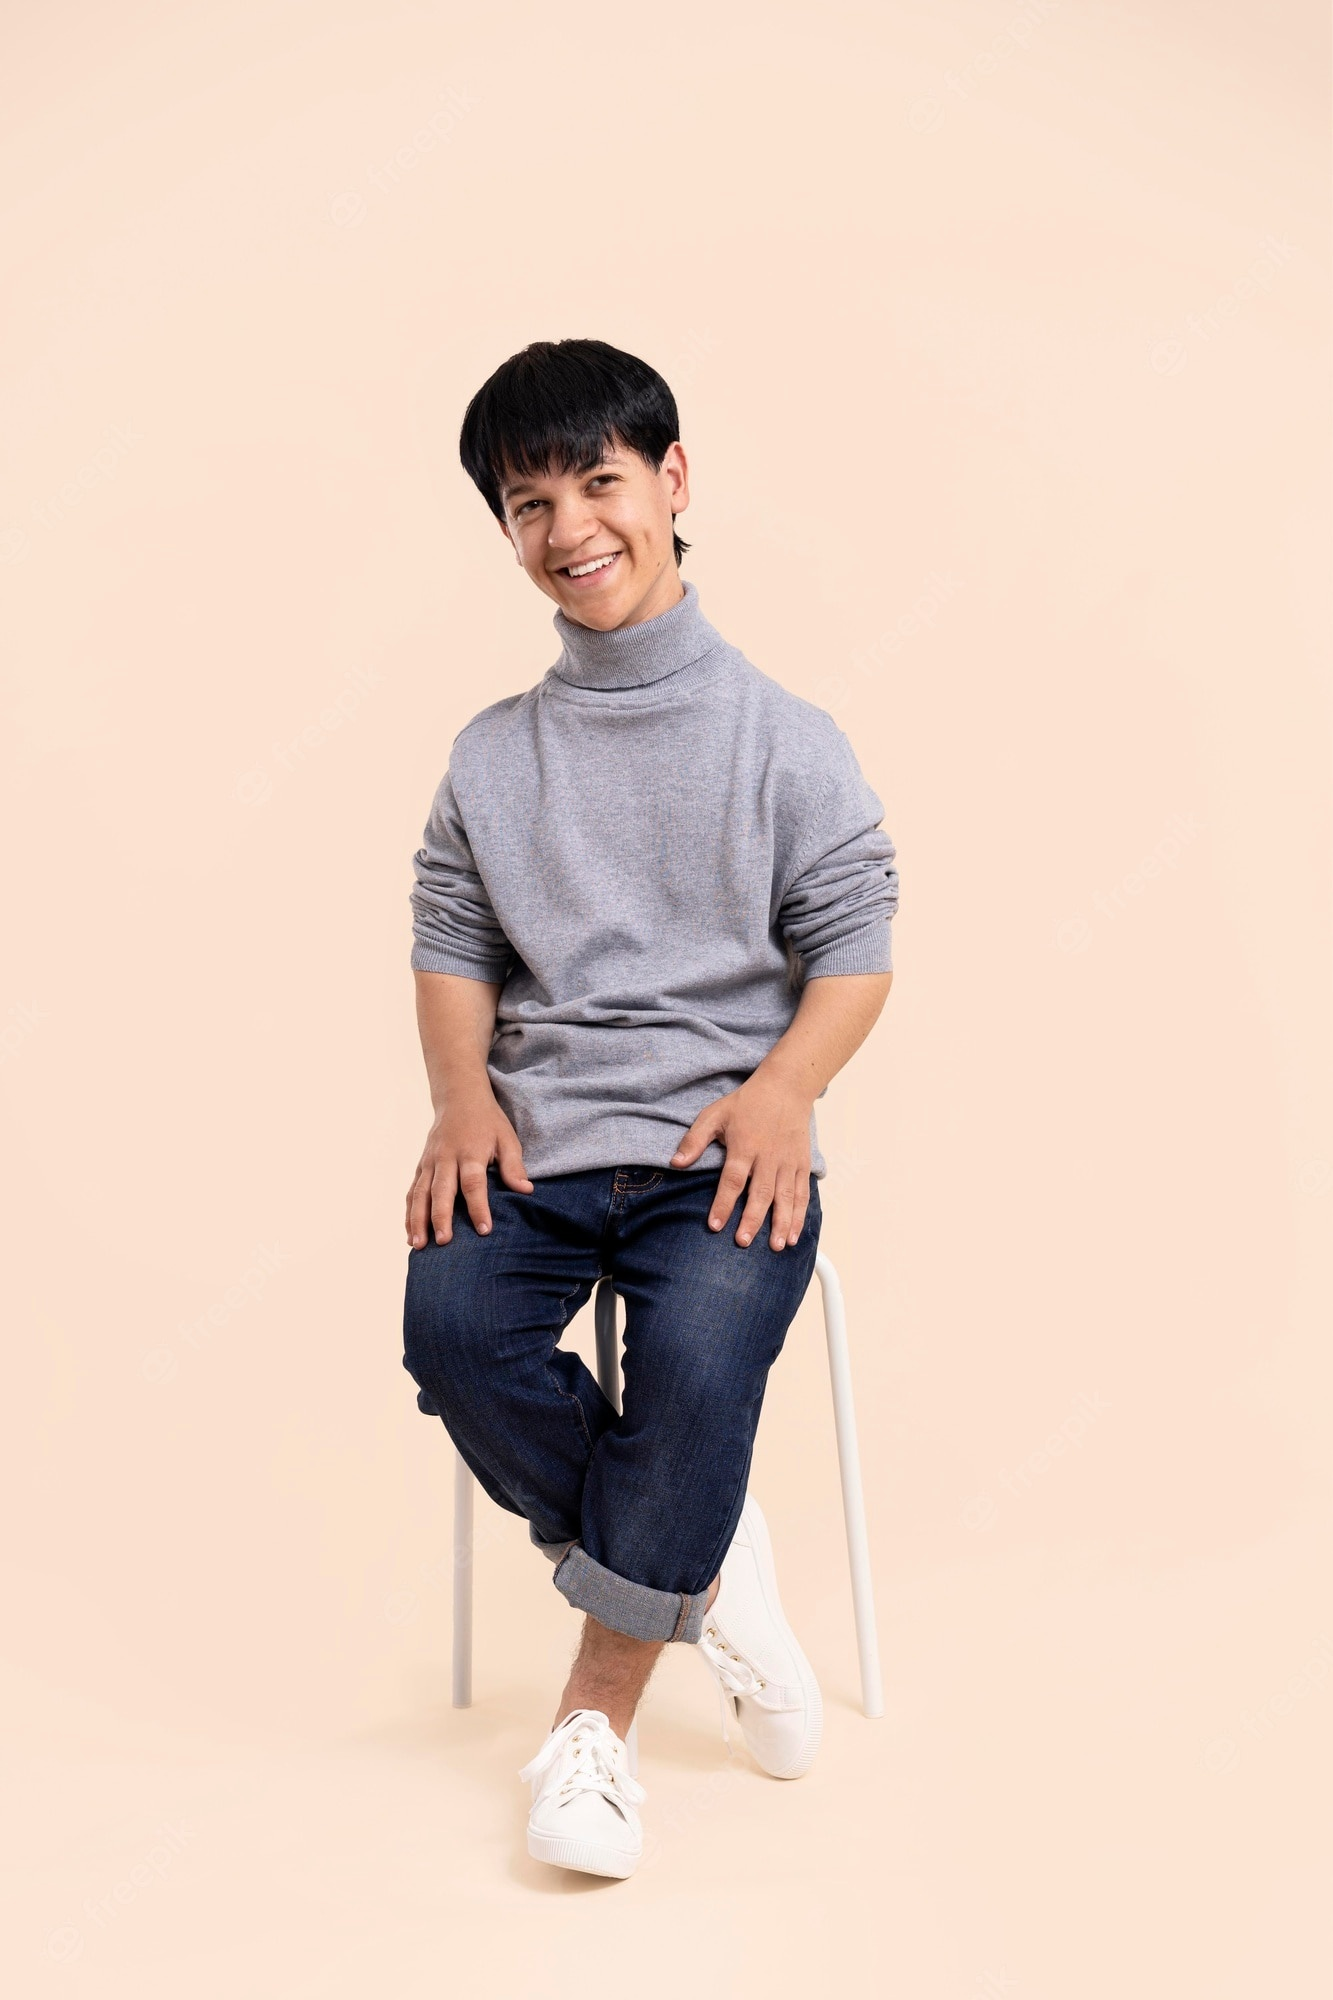

In [206]:
from IPython.display import display
for image_name in df["image_name"][:1]:
    img = Image.open(f"/kaggle/input/human-faces-object-detection/images/{image_name}")
    display(img)

#### Some images have more than one faces, for now dealing with images which have only onw face.

In [207]:
df2 = df.drop_duplicates(subset=['image_name'], keep=False)

In [208]:
df2.shape

(1713, 7)

#### Due to computation inabilities, using a subset of whole images which have a decent size, i.e. niether too large nor too small.

In [209]:
df2 = df2[200 < df2["width"]]
df2 = df2[df2["width"] < 600]
df2 = df2[df2["height"]<400]
df2 = df2[120 < df2["height"]]
df2.head()

,image_name,width,height,x0,y0,x1,y1
25,00003451.jpg,236,354,87,46,131,121
37,00001252.jpg,343,280,144,31,211,94
40,00003445.jpg,236,314,44,21,95,97
57,00003492.jpg,236,354,101,26,145,103
67,00003486.jpg,236,157,64,24,169,106


In [210]:
df2.shape

(218, 7)

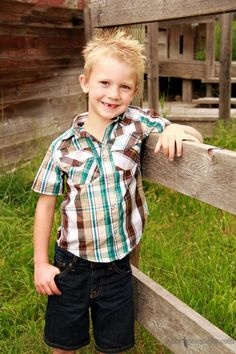

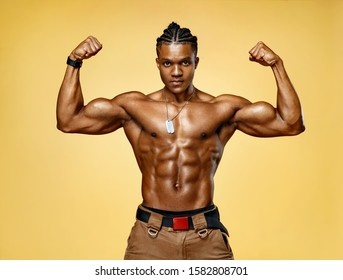

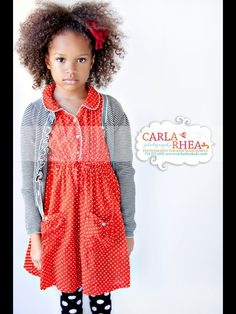

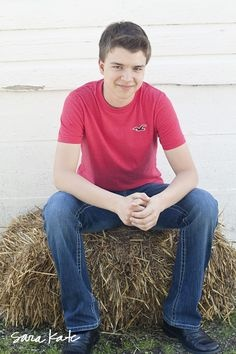

In [211]:
from IPython.display import display
for image_name in df2["image_name"][:4]:
    img = Image.open(f"/kaggle/input/human-faces-object-detection/images/{image_name}")
    display(img)

## Visualising the coordinates given

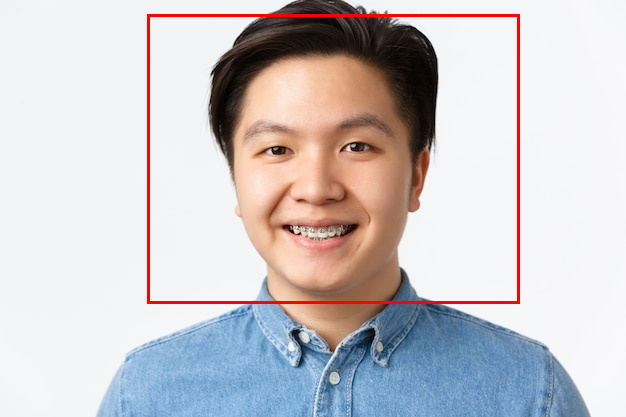

In [212]:
image_name = "00001736.jpg"
image_coord = [147,14 ,519,303]
img = Image.open(f"/kaggle/input/human-faces-object-detection/images/{image_name}")
upper_left = (image_coord[0], image_coord[1])
lower_right = (image_coord[2], image_coord[3]) 
draw = ImageDraw.Draw(img)
draw.rectangle([upper_left, lower_right], outline="red", width=3)  # Change color and width as desired
img

## Padding with black pixels

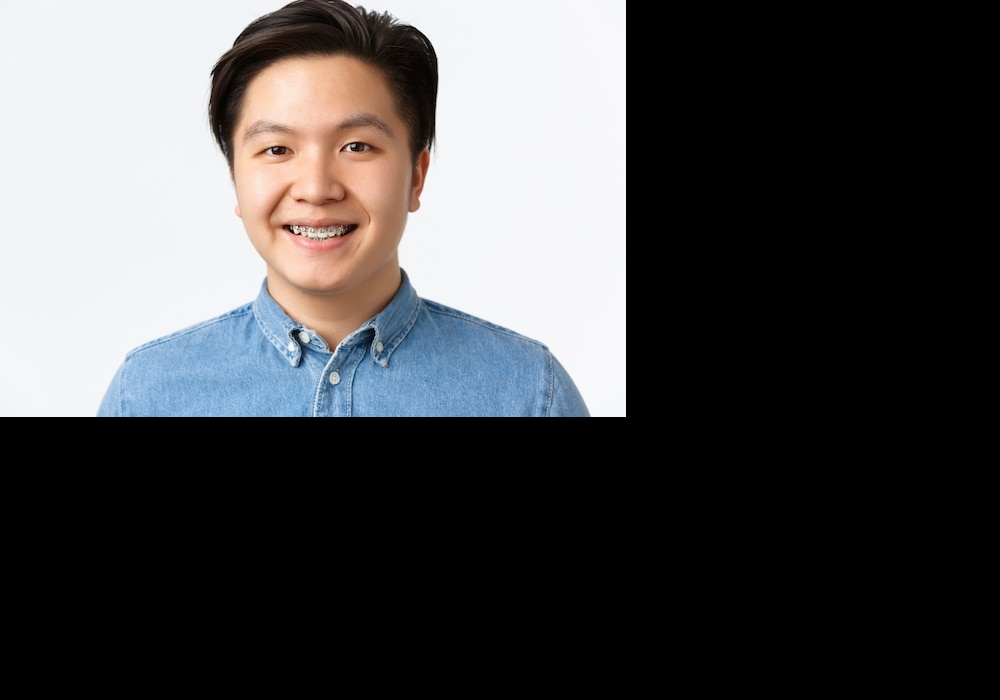

In [213]:
import numpy as np
from PIL import Image

def pad_image(image_name, target_size):
    padded_image = Image.new('RGB', target_size, color='black')
    image = Image.open(f"/kaggle/input/human-faces-object-detection/images/{image_name}")
    padded_image.paste(image)
    return padded_image

pad = pad_image("00001736.jpg", (1000,700))
pad

## X-y datasets and Train-test split

In [214]:
y = df2.iloc[:,3:7]
y.shape

(218, 4)

In [215]:
X_names = df2["image_name"]
X_names

25      00003451.jpg
37      00001252.jpg
40      00003445.jpg
57      00003492.jpg
67      00003486.jpg
            ...     
3296    00002971.jpg
3306    00003460.jpg
3335    00003104.jpg
3341    00003138.jpg
3343    00002540.jpg
Name: image_name, Length: 218, dtype: object

In [216]:
from sklearn.model_selection import train_test_split
X_names_train, X_names_test, y_train, y_test = train_test_split(X_names, y, test_size=0.25, random_state=42)

In [217]:
X_names_train = X_names_train.reset_index(drop=True)
X_names_test = X_names_test.reset_index(drop=True)

#### `X_names_train` and `X_names_test` only contains the names of the images. Now, creating 4-dimentionall arrays, `X_train` and `X_test` to give them as input to CNN model by converting each image to a 3-dimentional array.

In [218]:
X_train = np.array([np.array(pad_image(name, (600,400)))/255 for name in X_names_train])
X_test = np.array([np.array(pad_image(name, (600,400)))/255 for name in X_names_test])

In [219]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((163, 400, 600, 3), (163, 4), (55, 400, 600, 3), (55, 4))

## Model Training and Evaluation

In [220]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(400, 600, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4) 
])

model.compile(optimizer='adam',
              loss='mean_squared_error')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [221]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test , y_test))

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - loss: 24660.4277 - val_loss: 8130.2056
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - loss: 7076.5493 - val_loss: 10061.6934
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - loss: 8255.9385 - val_loss: 5120.0127
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 5355.4062 - val_loss: 4506.2646
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 4988.1719 - val_loss: 4360.3291
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - loss: 4663.1411 - val_loss: 4260.6846
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - loss: 3990.7634 - val_loss: 4210.8193
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 4004.9971 - val_loss: 3792.2861
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 3493.0229 - val_loss: 3852.9609
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - loss: 3369.3159 - val_loss: 3627.3547


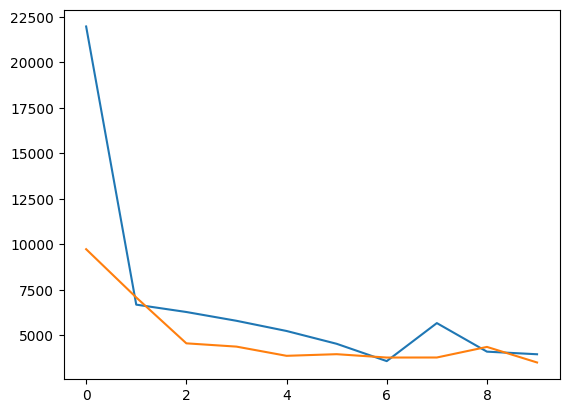

In [143]:
import matplotlib.pyplot as plt

training_loss = history.history['loss'][:]
val_loss = history.history["val_loss"][:]
plt.plot(training_loss)
plt.plot(val_loss)

In [222]:
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


In [223]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train , y_pred_train), mean_squared_error(y_test , y_pred), 

(3228.257875420659, 3620.3499112264817)

### Test predictions

In [225]:
pd.DataFrame(y_pred).head()

,0,1,2,3
0,92.728249,70.725212,160.992157,158.681549
1,173.899689,51.272007,364.937164,167.488708
2,76.527367,36.524101,166.787582,118.336662
3,139.948456,30.784105,311.814423,152.439438
4,96.723557,72.161705,162.257507,159.187775


### Some results from test images

/tmp/ipykernel_78/31521652.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  upper_left = (ac[0], ac[1])
/tmp/ipykernel_78/31521652.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_right = (ac[2], ac[3])


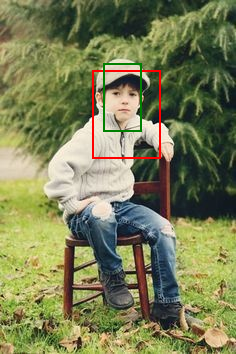

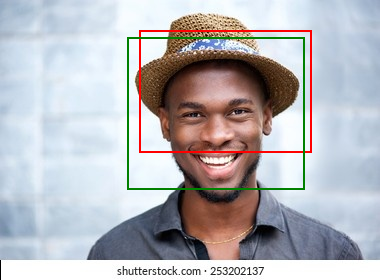

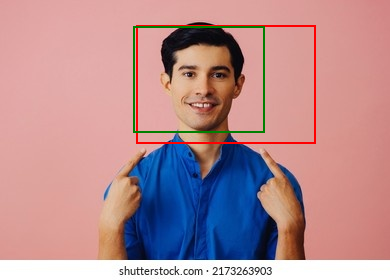

In [241]:
for i in [0,3,8]:
    image_name = X_names_test[i]
    img = Image.open(f"/kaggle/input/human-faces-object-detection/images/{image_name}")
    pc = y_pred[i]
    upper_left = (pc[0], pc[1])
    lower_right = (pc[2], pc[3]) 
    draw = ImageDraw.Draw(img)
    draw.rectangle([upper_left, lower_right], outline="red", width=2)
    ac = y_test.iloc[i]
    upper_left = (ac[0], ac[1])
    lower_right = (ac[2], ac[3]) 
    draw.rectangle([upper_left, lower_right], outline="green", width=2)
    display(img)

- Green rectangles are actual coordinates from the dataset
- Red rectangles are predictions of the coordinates